## __Import__

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from ast import literal_eval
from mplsoccer import Pitch, VerticalPitch, Standardizer


# Run the notebook from inside the notebooks folder
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))

from scripts.dataloader import Dataloader

dataloader = Dataloader()
dataloader.load_data()
df = dataloader.get_dimension(dimension="possession")
df.columns


[2025-08-06 14:05:30] Loading raw event data from local file system


Index(['player', 'player_id', 'type', 'duration', 'location', 'under_pressure',
       'carry_end_location', 'dribble_nutmeg', 'dribble_no_touch',
       'dribble_outcome', 'dribble_overrun', 'duel_type', 'duel_outcome',
       'counterpress', 'ball_receipt_outcome', 'foul_won_penalty',
       'miscontrol_aerial_won', 'pass_angle', 'pass_end_location'],
      dtype='object')

In [ ]:
# Setting types
def convert_to_list(input_data):
    if(isinstance(input_data, str)):
        try:
            return literal_eval(input_data)
        except (ValueError, SyntaxError):
            print(f"Error: The string {input_data} could not be converted to a list.")
            return None
    
    return input_data
    
df["location"] = df["location"].apply(convert_to_list)
# df["carry_end_location"] = df["carry_end_location"].apply(convert_to_list)
df[["x", "y"]] = df["location"].apply(pd.Series)
# df[["x_end_carry", "y_end_carry"]] = df["carry_end_location"].apply(pd.Series)

df["under_pressure"] = df['under_pressure'].fillna(False)
df.head()

,player,player_id,type,duration,location,under_pressure,carry_end_location,dribble_nutmeg,dribble_no_touch,dribble_outcome,...,duel_type,duel_outcome,counterpress,ball_receipt_outcome,foul_won_penalty,miscontrol_aerial_won,pass_angle,pass_end_location,x,y
6,Mark Uth,8387.0,Pass,0.453238,"[61.0, 40.1]",False,None,<NA>,<NA>,NaN,...,NaN,NaN,<NA>,NaN,<NA>,<NA>,-1.919567,"[60.2, 37.9]",61.0,40.1
7,Andrej Kramarić,5460.0,Pass,1.151865,"[59.4, 38.3]",False,None,<NA>,<NA>,NaN,...,NaN,NaN,<NA>,NaN,<NA>,<NA>,2.536994,"[53.9, 42.1]",59.4,38.3
8,Sebastian Rudy,6039.0,Pass,1.389406,"[52.3, 45.2]",False,None,<NA>,<NA>,NaN,...,NaN,NaN,<NA>,NaN,<NA>,<NA>,2.390664,"[34.3, 62.0]",52.3,45.2
9,Fabian Lukas Schär,5537.0,Pass,2.557696,"[34.3, 61.9]",False,None,<NA>,<NA>,NaN,...,NaN,NaN,<NA>,NaN,<NA>,<NA>,-1.487222,"[37.5, 23.7]",34.3,61.9
10,Tobias Strobl,12321.0,Pass,1.417774,"[38.5, 22.2]",False,None,<NA>,<NA>,NaN,...,NaN,NaN,<NA>,NaN,<NA>,<NA>,1.705317,"[36.7, 35.5]",38.5,22.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6391318,Matteo Mancosu,15415.0,Foul Won,0.000000,"[45.7, 38.3]",True,None,<NA>,<NA>,NaN,...,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,None,45.7,38.3
6391319,Mattia Destro,8103.0,Foul Won,0.200000,"[65.1, 42.6]",True,None,<NA>,<NA>,NaN,...,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,None,65.1,42.6
6391320,Luca Rossettini,7142.0,Foul Won,0.000000,"[32.3, 3.9]",True,None,<NA>,<NA>,NaN,...,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,None,32.3,3.9
6391321,Mattia Destro,8103.0,Foul Won,0.000000,"[68.7, 46.6]",True,None,<NA>,<NA>,NaN,...,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,None,68.7,46.6


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm


# prepare data
df_locations = df[["player", "player_id", "x", "y"]]
df_locations = df_locations.set_index("player_id")

standard_stats = pd.read_csv("../../data/new_approach/standard_stats_all_test.csv").loc[:,["player","player", "player_id","new_position","role"]]
standard_stats = standard_stats.set_index("player_id")

# join
df_combined = pd.merge(
    df_locations, 
    standard_stats[["new_position","role"]], 
    left_index=True, 
    right_index=True, 
    how='left'
)
df_combined

# define pitch for heatmap
pitch = VerticalPitch(positional=True, positional_color='#eadddd', shade_color='#f2f2f2')
# fig, ax = pitch.draw()
bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
bin_y = np.sort(np.array([pitch.dim.bottom, pitch.dim.six_yard_bottom,
                          pitch.dim.six_yard_top, pitch.dim.top]))

# calculate heatmap for each player
list_of_dfs = []
player_list = df_combined["player"].unique()
for player in tqdm(player_list):
    player_df = df_combined.loc[df_combined["player"] == player, ["x", "y"]]
    player_id = player_df.reset_index()["player_id"].iloc[0]
    bin_statistic = pitch.bin_statistic(player_df["x"], player_df["y"], statistic='count', bins=(8,4), normalize=True)
    bin_stastistic_1d = bin_statistic['statistic'].flatten()
    list_of_dfs.append(
        pd.DataFrame([bin_stastistic_1d], columns=[f"bin {i+1}" for i in range(len(bin_stastistic_1d))], index=[player_id])
    )
    # print(pd.DataFrame([bin_stastistic_1d], columns=[f"bin {i+1}" for i in range(len(bin_stastistic_1d))], index=[player_id]))


# join bins with postion and role
df_heatmap = pd.concat(list_of_dfs)
df_heatmap = df_heatmap.merge(
    standard_stats[["new_position", "role"]], 
    left_index=True, 
    right_index=True, 
    how='left'
)
df_heatmap.head()

100%|██████████| 2632/2632 [09:43<00:00,  4.51it/s]


,bin 1,bin 2,bin 3,bin 4,bin 5,bin 6,bin 7,bin 8,bin 9,bin 10,bin 11,bin 12,bin 13,bin 14,bin 15,bin 16,bin 17,bin 18,new_position,role
8387.0,0.001580,0.015271,0.028436,0.054239,0.048447,0.048447,0.006846,0.006319,0.025803,0.048973,0.048973,0.068984,0.026330,0.051080,0.110585,0.200632,0.135334,0.073723,Forward,Left Back
5460.0,0.000000,0.023500,0.075448,0.140383,0.149041,0.073593,0.000618,0.011750,0.024119,0.061843,0.072356,0.063080,0.000618,0.008658,0.047619,0.095857,0.110080,0.041435,Forward,Left Center Midfield
6039.0,0.010087,0.031271,0.057498,0.054808,0.039677,0.009751,0.015804,0.036987,0.083053,0.089442,0.040686,0.006052,0.021520,0.071284,0.141560,0.178884,0.088097,0.023537,Midfielder,Left Defensive Midfield
5537.0,0.002723,0.013224,0.003890,0.003890,0.001556,0.004278,0.052898,0.077013,0.085570,0.012835,0.008557,0.014391,0.084403,0.262933,0.262544,0.092571,0.016336,0.000389,Defender,Left Center Back
12321.0,0.025830,0.075953,0.122079,0.077183,0.016605,0.002153,0.022755,0.057503,0.075646,0.044895,0.013838,0.007688,0.031058,0.081796,0.153752,0.123309,0.050738,0.017220,Midfielder,Right Center Midfield
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7787.0,0.010381,0.006920,0.020761,0.000000,0.000000,0.000000,0.017301,0.044983,0.034602,0.010381,0.000000,0.017301,0.079585,0.339100,0.297578,0.110727,0.010381,0.000000,Defender,Right Center Back
20561.0,0.000000,0.095238,0.134921,0.253968,0.142857,0.039683,0.031746,0.000000,0.007937,0.015873,0.039683,0.007937,0.047619,0.023810,0.047619,0.095238,0.015873,0.000000,Midfielder,Right Center Midfield
386514.0,0.000000,0.015038,0.007519,0.022556,0.000000,0.000000,0.030075,0.127820,0.225564,0.007519,0.000000,0.015038,0.045113,0.255639,0.187970,0.060150,0.000000,0.000000,Defender,Right Center Back
41948.0,0.000000,0.061224,0.183673,0.183673,0.285714,0.000000,0.000000,0.061224,0.020408,0.061224,0.122449,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Midfielder,Left Center Midfield


In [152]:
# code to load json file
import json
with open('../../config/position_mapping_level_1.json', 'r') as file:
    position_mapping_level_1 = json.load(file)

reverse_mapping = {pos: level for level, positions in position_mapping_level_1.items() for pos in positions}
df_heatmap['position_level_1'] = df_heatmap['role'].map(reverse_mapping)
df_heatmap.head()

,bin 1,bin 2,bin 3,bin 4,bin 5,bin 6,bin 7,bin 8,bin 9,bin 10,...,bin 12,bin 13,bin 14,bin 15,bin 16,bin 17,bin 18,new_position,role,position_level_1
8387.0,0.001580,0.015271,0.028436,0.054239,0.048447,0.048447,0.006846,0.006319,0.025803,0.048973,...,0.068984,0.026330,0.051080,0.110585,0.200632,0.135334,0.073723,Forward,Left Back,Offensive Defender
5460.0,0.000000,0.023500,0.075448,0.140383,0.149041,0.073593,0.000618,0.011750,0.024119,0.061843,...,0.063080,0.000618,0.008658,0.047619,0.095857,0.110080,0.041435,Forward,Left Center Midfield,Central Midfielder
6039.0,0.010087,0.031271,0.057498,0.054808,0.039677,0.009751,0.015804,0.036987,0.083053,0.089442,...,0.006052,0.021520,0.071284,0.141560,0.178884,0.088097,0.023537,Midfielder,Left Defensive Midfield,Defensive Midfielder
5537.0,0.002723,0.013224,0.003890,0.003890,0.001556,0.004278,0.052898,0.077013,0.085570,0.012835,...,0.014391,0.084403,0.262933,0.262544,0.092571,0.016336,0.000389,Defender,Left Center Back,Regular Defender
12321.0,0.025830,0.075953,0.122079,0.077183,0.016605,0.002153,0.022755,0.057503,0.075646,0.044895,...,0.007688,0.031058,0.081796,0.153752,0.123309,0.050738,0.017220,Midfielder,Right Center Midfield,Central Midfielder


# level 2 position

In [165]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

def train_evaluate_model(X, y, model, scale=True, test_size=0.2, random_state=42):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Optional scaling
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluation
    return classification_report(y_test, y_pred, output_dict=True, zero_division=0)


def evaluate_multiple_models(X, y_encoded, label_encoder, scale=True):
    models = {
        "Logistic Regression": LogisticRegression(penalty="l1", solver="liblinear", C=1),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
        "SVM (poly kernel)": SVC(kernel='poly', random_state=42, gamma='auto'),
        "Gradient Boosting": GradientBoostingClassifier(),
    }

    results_all = {}

    for name, model in models.items():
        print(f"Training and evaluating: {name}")
        raw_results = train_evaluate_model(X, y_encoded, model, scale=scale)

        # Convert digit keys back to original class names
        label_map = dict(zip(map(str, range(len(label_encoder.classes_))), label_encoder.classes_))
        readable_results = {
            label_map[k] if k.isdigit() else k: v
            for k, v in raw_results.items()
        }

        results_all[name] = readable_results

    return results_all


# ---- Usage ----
# Assume df_heatmap is already defined
X = df_heatmap.drop(columns=["new_position", "role","position_level_1"])
y = df_heatmap["role"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Run and collect results (original features)
all_results = evaluate_multiple_models(X, y_encoded, le, scale=True)


# Print out accuracy of each model
for model_name, metrics in all_results.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    for label in le.classes_:
        if label in metrics:
            print(f"  {label} - Precision: {metrics[label]['precision']:.2f}, "
                  f"Recall: {metrics[label]['recall']:.2f}, F1: {metrics[label]['f1-score']:.2f}")


Training and evaluating: Logistic Regression
Training and evaluating: Random Forest
Training and evaluating: MLP Classifier
Training and evaluating: SVM (poly kernel)
Training and evaluating: Gradient Boosting

Model: Logistic Regression
Accuracy: 0.2770
  Center Attacking Midfield - Precision: 0.08, Recall: 0.06, F1: 0.07
  Center Back - Precision: 0.00, Recall: 0.00, F1: 0.00
  Center Defensive Midfield - Precision: 0.00, Recall: 0.00, F1: 0.00
  Center Forward - Precision: 0.11, Recall: 0.15, F1: 0.13
  Goalkeeper - Precision: 0.94, Recall: 1.00, F1: 0.97
  Left Attacking Midfield - Precision: 0.00, Recall: 0.00, F1: 0.00
  Left Back - Precision: 0.36, Recall: 0.62, F1: 0.45
  Left Center Back - Precision: 0.45, Recall: 0.65, F1: 0.53
  Left Center Forward - Precision: 0.12, Recall: 0.24, F1: 0.16
  Left Center Midfield - Precision: 0.00, Recall: 0.00, F1: 0.00
  Left Defensive Midfield - Precision: 0.00, Recall: 0.00, F1: 0.00
  Left Midfield - Precision: 0.11, Recall: 0.18, F1: 0.

In [161]:
from sklearn.cluster import KMeans
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Transform features to 2D using UMAP
umap_transformer = UMAP(n_components=2, init='random', random_state=42)
umap_2d_features:np.ndarray = umap_transformer.fit_transform(X)
umap_2d_features

# 2. Fit and predict with KMeans clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  
y_pred = kmeans.fit_predict(umap_2d_features)

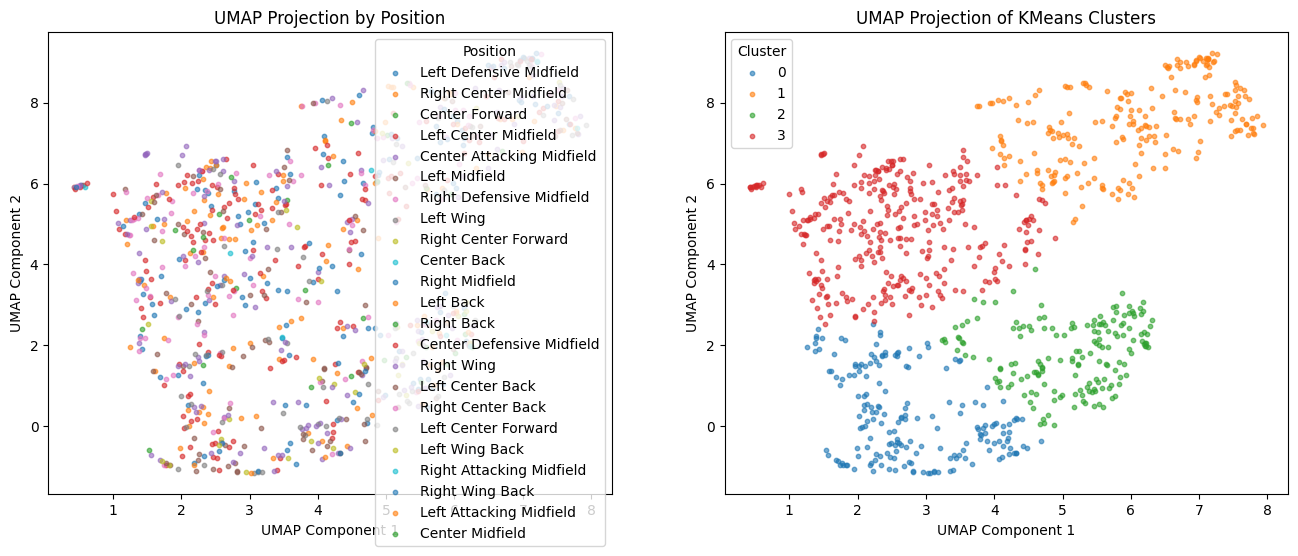

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: UMAP by position
unique_positions = y.unique()
palette = sns.color_palette("tab10", n_colors=len(unique_positions))
position_to_color = {pos: palette[i] for i, pos in enumerate(unique_positions)}

for pos in unique_positions:
    mask = y == pos
    axes[0].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=pos,
        color=position_to_color[pos]
    )
axes[0].set_title('UMAP Projection by Position')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].legend(title="Position")

# Right: UMAP by KMeans cluster
unique_clusters = np.unique(y_pred)
palette_clusters = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_to_color = {c: palette_clusters[i] for i, c in enumerate(unique_clusters)}

for c in unique_clusters:
    mask = y_pred == c
    axes[1].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=c,
        color=cluster_to_color[c]
    )
axes[1].set_title('UMAP Projection of KMeans Clusters')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].legend(title="Cluster")

#plt.tight_layout()
plt.show()


# level 1 position

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

def train_evaluate_model(X, y, model, scale=True, test_size=0.2, random_state=42):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Optional scaling
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluation
    return classification_report(y_test, y_pred, output_dict=True, zero_division=0)


def evaluate_multiple_models(X, y_encoded, label_encoder, scale=True):
    models = {
        "Logistic Regression": LogisticRegression(penalty="l1", solver="liblinear", C=1),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
        "SVM (poly kernel)": SVC(kernel='poly', random_state=42, gamma='auto'),
        "Gradient Boosting": GradientBoostingClassifier(),
    }

    results_all = {}

    for name, model in models.items():
        print(f"Training and evaluating: {name}")
        raw_results = train_evaluate_model(X, y_encoded, model, scale=scale)

        # Convert digit keys back to original class names
        label_map = dict(zip(map(str, range(len(label_encoder.classes_))), label_encoder.classes_))
        readable_results = {
            label_map[k] if k.isdigit() else k: v
            for k, v in raw_results.items()
        }

        results_all[name] = readable_results

    return results_all


# ---- Usage ----
# Assume df_heatmap is already defined
X = df_heatmap.drop(columns=["new_position", "role","position_level_1"])
y = df_heatmap["position_level_1"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Run and collect results (original features)
all_results = evaluate_multiple_models(X, y_encoded, le, scale=True)

# Print out accuracy of each model
for model_name, metrics in all_results.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    for label in le.classes_:
        if label in metrics:
            print(f"  {label} - Precision: {metrics[label]['precision']:.2f}, "
                  f"Recall: {metrics[label]['recall']:.2f}, F1: {metrics[label]['f1-score']:.2f}")



Training and evaluating: Logistic Regression
Training and evaluating: Random Forest
Training and evaluating: MLP Classifier
Training and evaluating: SVM (poly kernel)
Training and evaluating: Gradient Boosting

Model: Logistic Regression
Accuracy: 0.3812
  Central Midfielder - Precision: 0.39, Recall: 0.64, F1: 0.48
  Defensive Midfielder - Precision: 0.40, Recall: 0.42, F1: 0.41
  Offensive Defender - Precision: 0.00, Recall: 0.00, F1: 0.00
  Offensive Midfielder - Precision: 0.00, Recall: 0.00, F1: 0.00
  Regular Defender - Precision: 0.00, Recall: 0.00, F1: 0.00
  Striker - Precision: 0.22, Recall: 0.14, F1: 0.17
  Winger - Precision: 0.00, Recall: 0.00, F1: 0.00

Model: Random Forest
Accuracy: 0.4144
  Central Midfielder - Precision: 0.43, Recall: 0.69, F1: 0.53
  Defensive Midfielder - Precision: 0.42, Recall: 0.46, F1: 0.44
  Offensive Defender - Precision: 0.00, Recall: 0.00, F1: 0.00
  Offensive Midfielder - Precision: 0.00, Recall: 0.00, F1: 0.00
  Regular Defender - Precision

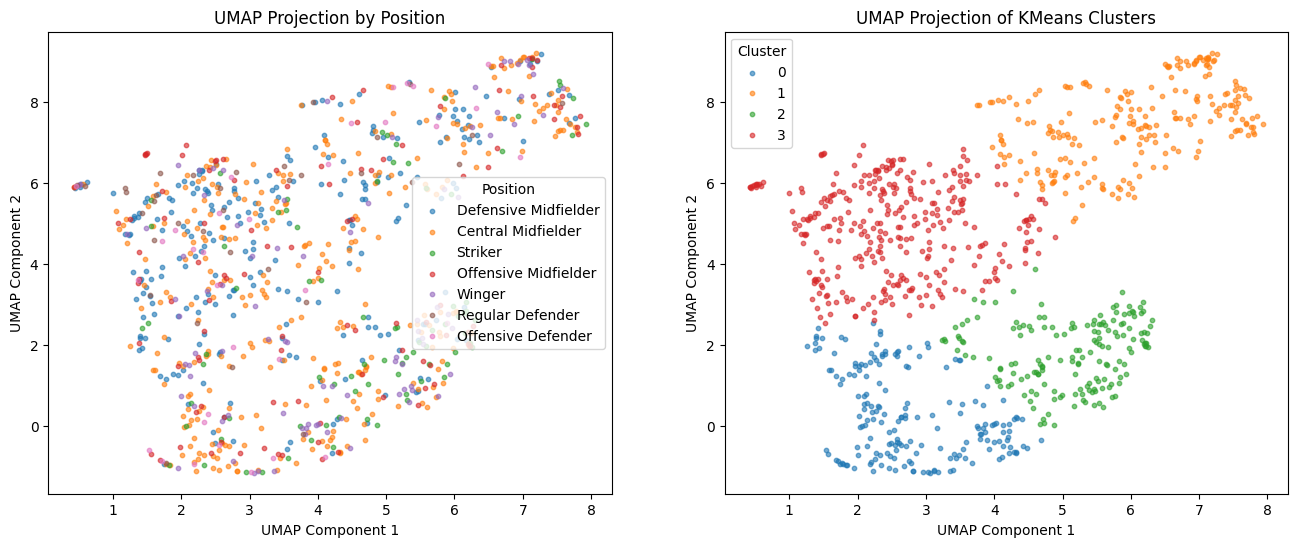

In [164]:
from sklearn.cluster import KMeans
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Transform features to 2D using UMAP
umap_transformer = UMAP(n_components=2, init='random', random_state=42)
umap_2d_features:np.ndarray = umap_transformer.fit_transform(X)
umap_2d_features

# 2. Fit and predict with KMeans clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  
y_pred = kmeans.fit_predict(umap_2d_features)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: UMAP by position
unique_positions = y.unique()
palette = sns.color_palette("tab10", n_colors=len(unique_positions))
position_to_color = {pos: palette[i] for i, pos in enumerate(unique_positions)}

for pos in unique_positions:
    mask = y == pos
    axes[0].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=pos,
        color=position_to_color[pos]
    )
axes[0].set_title('UMAP Projection by Position')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].legend(title="Position")

# Right: UMAP by KMeans cluster
unique_clusters = np.unique(y_pred)
palette_clusters = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_to_color = {c: palette_clusters[i] for i, c in enumerate(unique_clusters)}

for c in unique_clusters:
    mask = y_pred == c
    axes[1].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=c,
        color=cluster_to_color[c]
    )
axes[1].set_title('UMAP Projection of KMeans Clusters')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].legend(title="Cluster")

#plt.tight_layout()
plt.show()

# Plot Heatmap

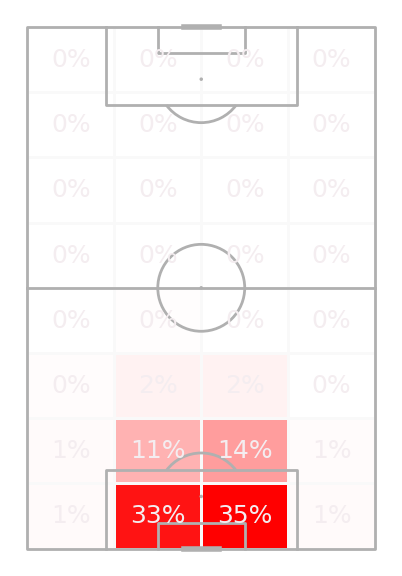

In [71]:
from matplotlib.colors import LinearSegmentedColormap

player = "Manuel Neuer"
player_a = df.loc[df["player"]==player,:]


# Create a custom colormap starting from white to red
cmap = LinearSegmentedColormap.from_list("white_to_red", ["#ffffff", "#ff0000"])
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2)
fig, ax = pitch.draw(figsize=(4.125, 6))

# Bin the player stats and normalize them
bin_statistic = pitch.bin_statistic(player_a["x"], player_a["y"], statistic='count', bins=(8,4), normalize=True)


pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}')


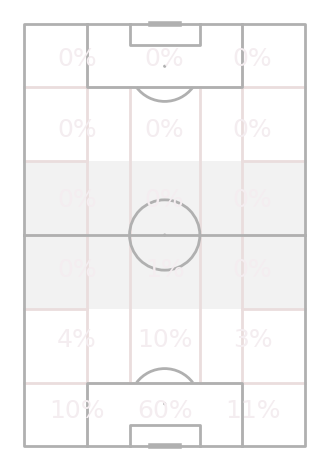

In [78]:
pitch = VerticalPitch(positional=True, shade_middle=True, positional_color='#eadddd', shade_color='#f2f2f2')
fig, ax = pitch.draw()
bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
bin_y = np.sort(np.array([pitch.dim.bottom, pitch.dim.six_yard_bottom,
                          pitch.dim.six_yard_top, pitch.dim.top]))
bin_statistic = pitch.bin_statistic(player_a["x"], player_a["y"], statistic='count',
                                    bins=(bin_x, bin_y), normalize=True)

labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}')


In [82]:
bin_statistic["statistic"].flatten()

array([0.        , 0.00052659, 0.00210637, 0.00210637, 0.00842549,
       0.00789889, 0.00526593, 0.00631912, 0.00842549, 0.01000527,
       0.00052659, 0.00105319, 0.00263296, 0.01000527, 0.00368615,
       0.01421801, 0.01053186, 0.01369142, 0.01579779, 0.00842549,
       0.00052659, 0.        , 0.00263296, 0.00210637, 0.00895208,
       0.00842549, 0.01579779, 0.00895208, 0.01053186, 0.00684571,
       0.00157978, 0.00210637, 0.        , 0.00421274, 0.01316482,
       0.01316482, 0.0073723 , 0.01579779, 0.01895735, 0.02317009,
       0.00210637, 0.00368615, 0.00157978, 0.00210637, 0.00842549,
       0.01316482, 0.0226435 , 0.01790416, 0.01632438, 0.01843075,
       0.        , 0.00421274, 0.00526593, 0.00631912, 0.01211164,
       0.01843075, 0.03896788, 0.03475513, 0.02790943, 0.0147446 ,
       0.00526593, 0.00421274, 0.00842549, 0.0221169 , 0.01421801,
       0.04949974, 0.03896788, 0.02843602, 0.01579779, 0.00789889,
       0.00579252, 0.01263823, 0.01579779, 0.03844128, 0.03317

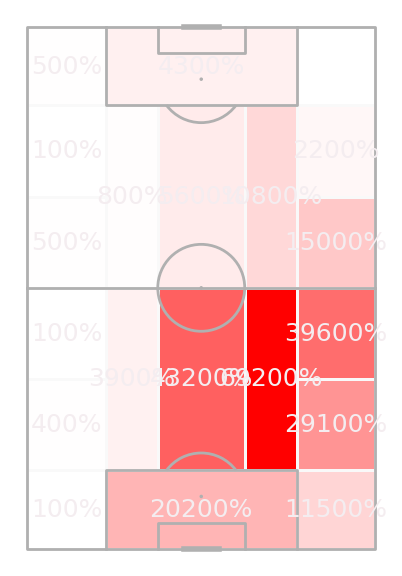

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

player = "Fabian Lukas Schär"
player_a = df.loc[df["player"]==player,:]


# Create a custom colormap starting from white to red
cmap = LinearSegmentedColormap.from_list("white_to_red", ["#ffffff", "#ff0000"])
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2)
fig, ax = pitch.draw(figsize=(4.125, 6))

# Bin the player stats and normalize them
bin_statistic = pitch.bin_statistic_positional(player_a["x"], player_a["y"], statistic='count', positional="full", normalize=True)


pitch.heatmap_positional(bin_statistic, ax=ax, cmap=cmap, edgecolor='#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=ax, ha='center', va='center',
                             str_format='{:.0%}',exclude_zeros=True)


In [50]:
bin_statistic

[{'statistic': array([[0.00038895, 0.00155581, 0.00038895, 0.00194477, 0.00038895,
          0.00194477]]),
  'x_grid': array([[  0.,  18.,  39.,  60.,  81., 102., 120.],
         [  0.,  18.,  39.,  60.,  81., 102., 120.]]),
  'y_grid': array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [18., 18., 18., 18., 18., 18., 18.]]),
  'cx': array([  9. ,  28.5,  49.5,  70.5,  91.5, 111. ]),
  'cy': array([9., 9., 9., 9., 9., 9.]),
  'binnumber': None,
  'inside': None,
  'angle_grid': None,
  'angle_widths': None},
 {'statistic': array([[0.04472968, 0.11318553, 0.15402567, 0.05834306, 0.00855698,
          0.        ]]),
  'x_grid': array([[  0.,  18.,  39.,  60.,  81., 102., 120.],
         [  0.,  18.,  39.,  60.,  81., 102., 120.]]),
  'y_grid': array([[62., 62., 62., 62., 62., 62., 62.],
         [80., 80., 80., 80., 80., 80., 80.]]),
  'cx': array([  9. ,  28.5,  49.5,  70.5,  91.5, 111. ]),
  'cy': array([71., 71., 71., 71., 71., 71.]),
  'binnumber': None,
  'inside': None,
  'angle_

# Tests

<Axes: xlabel='x', ylabel='y'>

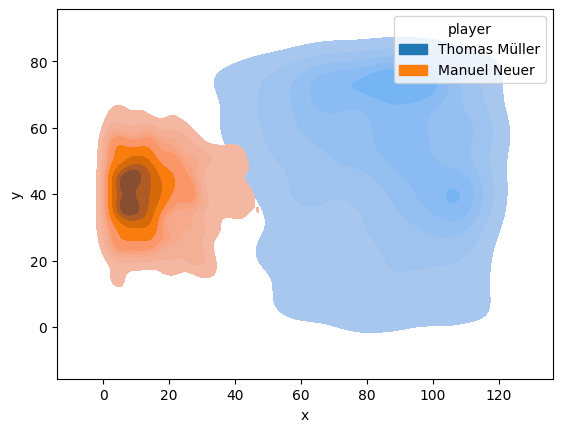

In [2]:
import seaborn as sns

player_1 = df.loc[(df["player"]=="Manuel Neuer") | (df["player"]=="Thomas Müller") ,:]
player_1
sns.kdeplot(data=player_1, x="x", y="y",  hue="player", fill=True)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Sample data
#data = np.random.normal(size=100)
data = np.stack([player_1["x"], player_1["y"]]).T
# Create a gaussian KDE object
kde = gaussian_kde(data)

# Define a grid where you want to evaluate the KDE
x_grid = np.linspace(min(data), max(data), 100)

# Evaluate the KDE on the grid
kde_values = kde.evaluate(x_grid)

# Plot the result using matplotlib
plt.plot(x_grid, kde_values, label='KDE')
plt.fill_between(x_grid, kde_values, alpha=0.5)  # Optional: Fill under the curve
plt.title('Kernel Density Estimate')
plt.xlabel('Data Points')
plt.ylabel('Density')
plt.legend()
plt.show()


ValueError: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

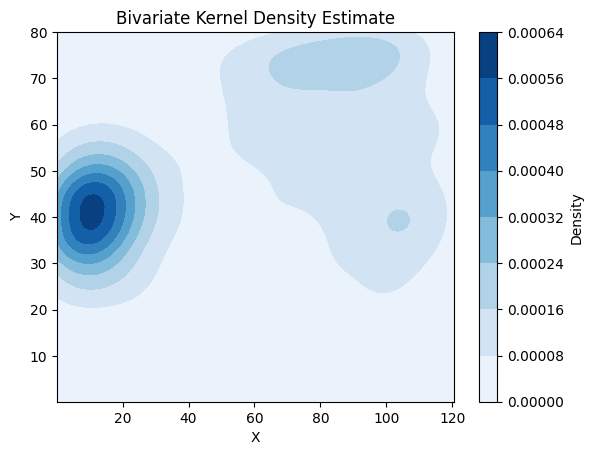

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Sample data (replace with your dataframe)
data = np.stack([player_1["x"], player_1["y"]]).T

# Create a gaussian KDE object
kde = gaussian_kde(data.T)  # Transpose the data for bivariate kde

# Define a grid to evaluate the KDE
x_grid = np.linspace(min(df["x"]), max(df["x"]), 100)
y_grid = np.linspace(min(df["y"]), max(df["y"]), 100)
X, Y = np.meshgrid(x_grid, y_grid)

# Evaluate the KDE on the grid (reshaping the meshgrid for evaluation)
grid_points = np.vstack([X.ravel(), Y.ravel()])
kde_values = kde(grid_points).reshape(X.shape)

# Plot the result using contour plot for bivariate KDE
plt.contourf(X, Y, kde_values, cmap='Blues')
plt.colorbar(label='Density')
plt.title('Bivariate Kernel Density Estimate')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
